In [48]:
import os
import pandas as pd
import rdkit.Chem

from rlmolecule.sql.run_config import RunConfig
from stable_radical_problem import construct_problem
from rlmolecule.sql.tables import GameStore, RewardStore

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False}
)

In [49]:
config = RunConfig('config_local.yaml')
problem = construct_problem(config)

In [50]:
df_games = pd.read_sql(
    problem.session
    .query(GameStore)
    .filter_by(run_id=config.run_id)
    .statement, problem.session.bind)


df_games['time_hours'] = (
    (df_games.time - df_games.time.min())
    .apply(lambda x: x.total_seconds() / 3600)
)
df_games = df_games.sort_values('time_hours')
df_games.reset_index(drop=True, inplace=True)
df_games.shape

(1124, 8)

In [51]:
policy_dir = os.path.join(
    config.train_config.get('policy_checkpoint_dir'),
    config.run_id)

log = pd.read_csv(os.path.join(policy_dir, "log.csv"))
log['time'] = pd.to_datetime(log.time) - df.time.min()
log['time_hours'] = (log.time).apply(lambda x: x.total_seconds() / 3600)

In [52]:
all_final_molecules = (
    problem.session
    .query(RewardStore)
    .filter_by(run_id=problem.run_id)
)

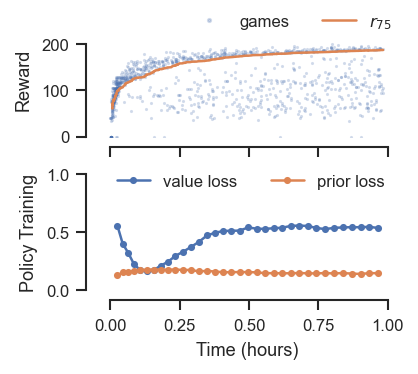

In [53]:
fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(2.75, 2.5), dpi=150)

axs[0].plot(df_games.time_hours, df_games.raw_reward, '.', ms=1, label='games', rasterized=True, alpha=0.25)
axs[0].plot(df_games.time_hours, df_games.raw_reward.rolling(250, min_periods=50).quantile(.75), label='$r_{75}$')

if log is not None:
    axs[1].plot(log.time_hours, log.policy_wrapper_loss, '.-', label='value loss')
    axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, '.-', label='prior loss')

leg = axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0.3, bbox_to_anchor=(1., 1.1), markerscale=3)
# for lh in leg.legendHandles: 
#     lh._legmarker.set_alpha(1)
    
axs[1].legend(loc='upper right', ncol=2, borderpad=None, borderaxespad=0.3, bbox_to_anchor=(1., 1.1))


axs[0].set_ylabel('Reward')
axs[1].set_ylabel('Policy Training')
axs[1].set_xlabel('Time (hours)')

axs[0].set_ylim([0, 250])
axs[1].set_ylim([0, 1.])
# axs[1].set_xlim([-.01, 4])

plt.tight_layout()
sns.despine(offset=5, trim=True)


In [63]:
df_rewards = pd.read_sql(
    problem.session.query(RewardStore)
    .filter_by(run_id=run_config.run_id)
    .filter(RewardStore.reward >= 195)
    .statement, problem.session.bind)

df_rewards.shape

(43, 6)

In [64]:
def process(x):
    mol = rdkit.Chem.MolFromSmiles(x)
    for atom in mol.GetAtoms():
        if atom.GetNumRadicalElectrons() == 1:
            radical_idx = atom.GetIdx()
            symbol = atom.GetSymbol()
            break            
    else:
        radical_idx = None
        symbol = None
        
    return pd.Series({'radical_idx': radical_idx,
                      'symbol': symbol,
                      'num_atoms': mol.GetNumAtoms()})


df_data = pd.DataFrame(df_rewards.data.tolist())
df_data['ionization_energy'] = df_data.ionization_energy.astype(float)
df_data['electron_affinity'] = df_data.electron_affinity.astype(float)
df_data['max_spin'] = df_data.max_spin.astype(float)
df_data['spin_buried_vol'] = df_data.spin_buried_vol.astype(float)
df_rewards = df_rewards.join(df_data)

annotated_rewards = df_rewards.join(df_rewards.smiles.apply(process))
annotated_rewards = annotated_rewards.sort_values(
    ['num_atoms', 'reward'], ascending=[True, False])

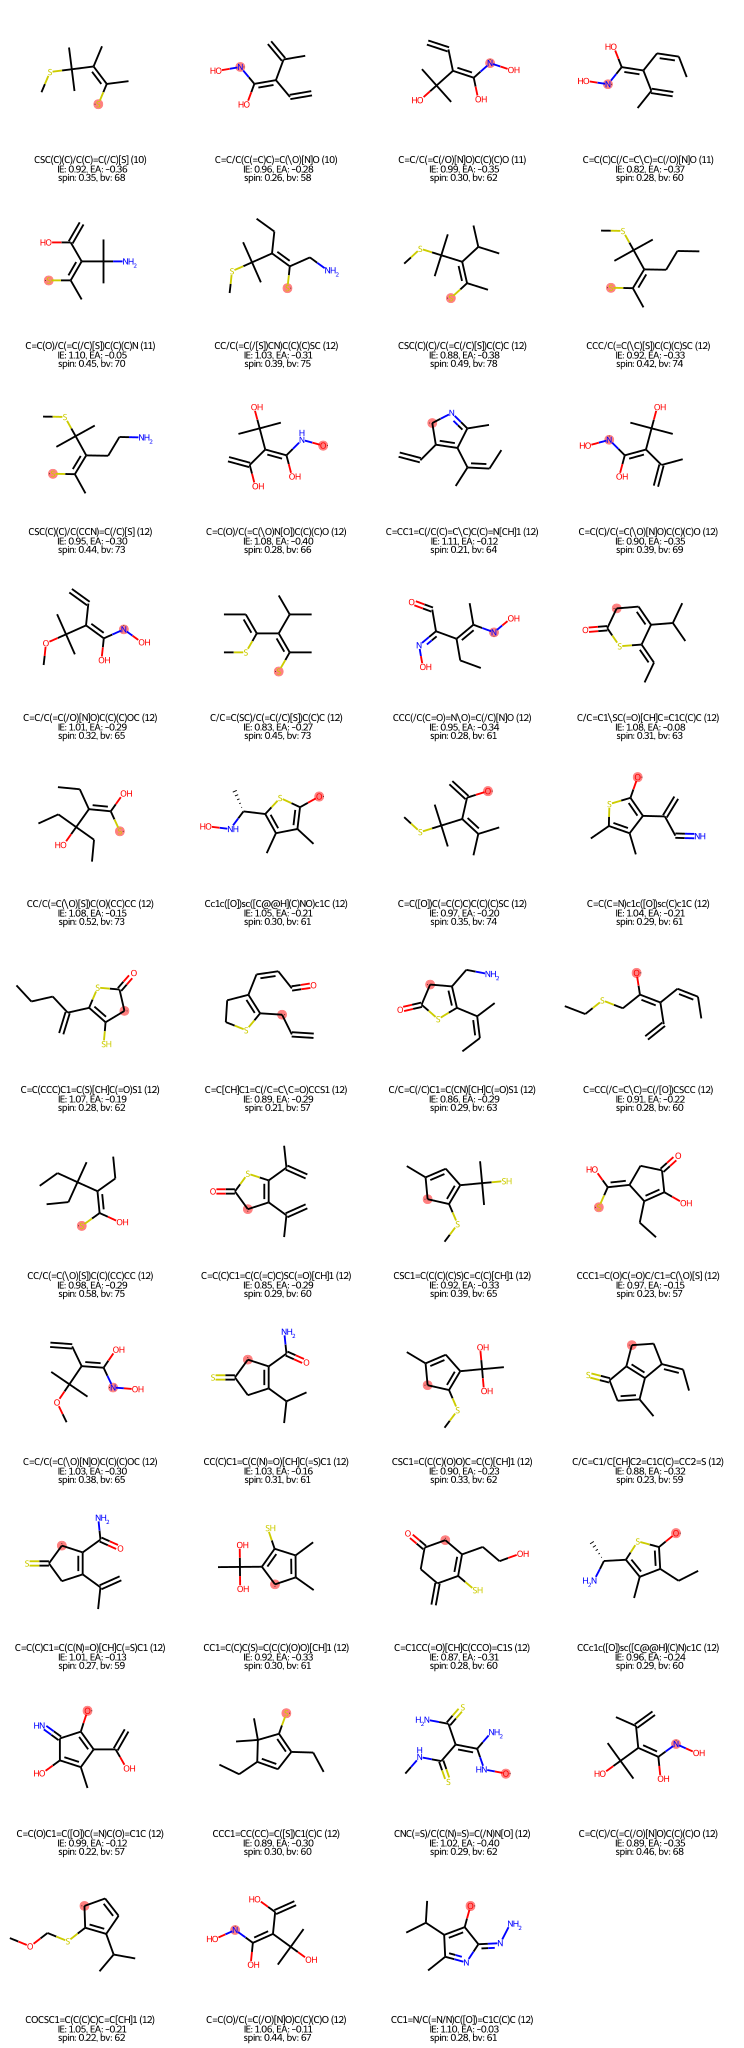

In [67]:
from rdkit.Chem.Draw import MolsToGridImage, rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.legendFontSize = 60
IPythonConsole.drawOptions.addAtomIndices = False

img = IPythonConsole.ShowMols(
    annotated_rewards.smiles.apply(
        rdkit.Chem.MolFromSmiles), molsPerRow=4, subImgSize=(200, 200),
    legends=annotated_rewards.apply(
        lambda x: f'{x.smiles} ({x.num_atoms})\n'
        f'IE: {x.ionization_energy:.2f}, EA: {x.electron_affinity:.2f}\n'
        f'spin: {x.max_spin:.2f}, bv: {x.spin_buried_vol:.0f}', 1).values.tolist(),
    highlightAtomLists=[[i] for i in annotated_rewards.radical_idx],
    useSVG=True)

img